# Week2 One-way ANOVA-方差稳定化变换
## 背景描述
这里对五种绝缘材料的性能进行实验研究。我们在升高电压的情况下对每种材料的四个样本进行测试，以加速失效时间。
这是一个因子水平数 a = 5 和重复次数 n = 4 的单因子实验。

## 数据描述
|    变量名    |   变量含义   |   变量类型   |   变量取值范围   |
| :----------: | :--------: | :----------: | :----------: |
| （自变量）Material | 绝缘材料类型 | categorical variable | [1, 2, 3, 4, 5] |
| （因变量）Failure Time | 失效时间 | continuous variable（单位：分钟） | Real |

In [1]:
import pandas as pd
print('Data: \n', pd.read_csv('Project2.csv').values)

Data: 
 [[    1     1   110]
 [    2     1   157]
 [    3     1   194]
 [    4     1   178]
 [    5     2     1]
 [    6     2     2]
 [    7     2     4]
 [    8     2    18]
 [    9     3   880]
 [   10     3  1256]
 [   11     3  5276]
 [   12     3  4355]
 [   13     4   495]
 [   14     4  7040]
 [   15     4  5307]
 [   16     4 10050]
 [   17     5     7]
 [   18     5     5]
 [   19     5    29]
 [   20     5     2]]


## 问题 
注：这里使用 $\alpha$=0.05 的显著性水平

1. 试判断 5 种绝缘材料的性能是否存在差异.
2. 试判断该实验残差是否具有异方差性.
3. 若实验中的残差具有异方差性，试判断失效时间如何进行方差稳定化变换.
5. 如果需要变换，基于变换后的数据，试判断 5 种绝缘材料的性能是否存在差异.

## 解决方案
**Q1:**  
检验假设 $H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4$ ;  $H_1: \mu_1, \mu_2, \mu_3, \mu_4$不全相等。

在本问题中，采用单因子方差分析模型（One-way ANOVA模型）对问题进行分析。计算得出方差分析表，然后计算出检验统计量F。若$F\ge F_{1-\alpha}(f_A,f_e)$，说明$H_0$成立，因子不显著；否则说明$H_0$不成立，说明因子显著。其中$f_A,f_e$分别为因子和误差的自由度。

利用python进行分析得到的具体分析结果如下：

In [2]:
# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import special
import matplotlib.pyplot as plt
import math

# Import additional packages
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f

alpha = 0.05
a = 5
n = 4

x = pd.read_csv("Project2.csv")
data = x.values[:,1:3]
data = data.astype(float) 
# 不加此句，在进行变换时会取整，导致误差
# print(data)

# Sort them into groups, according to column 1("Material")
group1 = data[data[:,0] == 1,1]
group2 = data[data[:,0] == 2,1]
group3 = data[data[:,0] == 3,1]
group4 = data[data[:,0] == 4,1]
group5 = data[data[:,0] == 5,1]

# Do the one-way ANOVA
df = pd.DataFrame(data, columns = ['Material', 'Failure_Time'])   
model = ols('Failure_Time ~ C(Material)', df).fit()
anovaResults = round(anova_lm(model), 4)
print('The ANOVA table: \n', anovaResults)

F0, pVal1 = stats.f_oneway(group1, group2, group3, group4, group5)
# 法1：
# print(pVal1)
if pVal1 < alpha:
    print('\nSince p-value < '+str(alpha)+', reject H0.')
else:
    print('\nAccept H0.') 
    
# 法2：
F = round(f.ppf(0.95,dfn = a-1,dfd = a*n-a), 4)
if F0 > F:
    print('Since F0 > F('+str(1-alpha)+', '+str(a-1)+', '+str(a*n-a)+') = ', F, ', reject H0.')
else:
    print('Accept H0.') 


The ANOVA table: 
                df       sum_sq     mean_sq       F  PR(>F)
C(Material)   4.0  103191489.2  25797872.3  6.1909  0.0038
Residual     15.0   62505657.0   4167043.8     NaN     NaN

Since p-value < 0.05, reject H0.
Since F0 > F(0.95, 4, 15) =  3.0556 , reject H0.


由方差分析表可知，P值小于 0.05 且F值大于 3.06，落入拒绝域$W=\{F\ge F_{1-\alpha}(f_A,f_e)\}$中，故拒绝原假设$H_0$，说明因子显著，即 5 种绝缘材料的性能存在差异。

**Q2:**  
ANOVA模型： 
$y_{ij} = \mu + \tau_i + \epsilon_{ij}$ 的误差服从正态独立分布，其均值为零，方差为未知的常数$\sigma^2$。 
想要判断ANOVA模型是否恰当，可以利用残差检测来进行分析。  
处理 $i$ 的观测值 $j$ 的残差定义为：$e_{ij} = y_{ij} - \hat{y}_{ij}$  
其中$\hat{y}_{ij}$是对应于$y_{ij}$的一个估计， 
$\hat{y}_{ij} = \hat{\mu} + \hat{\tau}_i = \overline{y}_{··} + (\overline{y}_{i·} - \overline{y}_{··}) = \overline{y}_{i·}$  

对数据的方差齐性进行检验，不满足方差齐性即说明数据具有异方差性，需要对原始数据进行变换然后再进行方差分析，方差齐性的检验假设为：$H_0:\sigma_1^2 = \sigma_2^2 = ⋯ = \sigma_a^2$  vs $H_1:\sigma_i^2 \neq \sigma_j^2, ∃ i \neq j.$  
编写python程序来判断数据的异方差性，判断依据主要有：残差与拟合值的关系图，Bartlett检验及Levene检验。

Bartlett检验的P值为： 3.608342631295821e-15
Since p-value < 0.05, reject H0.

Levene检验的P值为： 0.0043438474446047285
Since p-value < 0.05, reject H0.



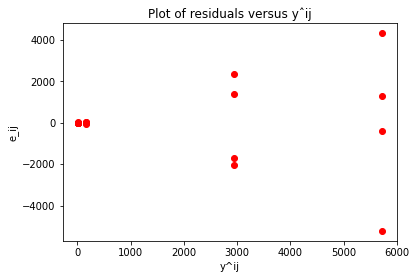

In [3]:
# 计算峰值流量的残差
data_res = data.astype(float) * 1
for k in range(a):
    cnt = data_res[data_res[:,0] == k + 1,1]
    data_res[data_res[:,0] == k + 1,1] = cnt - np.mean(cnt)
# print(data_res)

# 法1：残差与拟合值的关系图
res = data_res[:,1]
y = []
for i in range(a):
    for j in range(n):
        y.append(np.mean(data[(data[:,0] == i + 1),1]))
plt.scatter(y, res, c = "red")
plt.title('Plot of residuals versus yˆij')
plt.xlabel('y^ij')
plt.ylabel('e_ij')

# 法2：用Bartlett检验进行方差齐性检验
bart, pVal2 = stats.bartlett(group1, group2, group3, group4, group5)
bart_stat = stats.chi2.isf(alpha, a - 1)
print('Bartlett检验的P值为：', pVal2)
if pVal2 < alpha:
    print('Since p-value < 0.05, reject H0.')
else:
    print('Accept H0')  

# 法3：用Levene检验进行方差齐性检验
lene, pVal3 = stats.levene(group1, group2, group3, group4, group5)
print('\nLevene检验的P值为：', pVal3)
if pVal3 < alpha:
    print('Since p-value < 0.05, reject H0.\n')
else:
    print('Accept H0\n')  

由分析可知:  
1. 残差与拟合值的关系图：呈现开口向外的漏斗型；
2. Bartlett 检验法：P值接近0，$3.6\times 10^{-15}$ < 0.05；
3. Levene检验法：P值为 0.0043 < 0.05.  

由以上三种方法得出共同结论：拒绝方差相等的原假设。即认为数据具有异方差性，需要对数据进行变换。

**Q3:**  
由第二题的结论可知，残差具有异方差性。由残差与拟合值的关系图可以看出，随着$\hat{y}_{ij}$的增大，残差不断增大，每组数据的方差也随之增大。为了研究峰值流量如何采用方差稳定化变换，需画出$logS_i$和$log\overline{y}_{i·}$的关系图。这是为了找出每一组内方差随均值变化的规律并由此进行变换。同时由于组间的方差和均值差距较大，所以对横纵坐标同时取了对数。

斜率为： 0.92


Text(0, 0.5, 'log_Si')

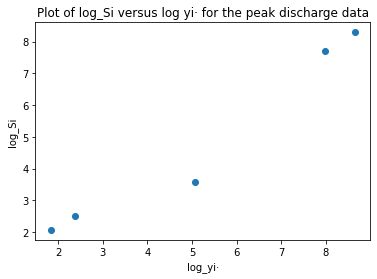

In [4]:
# 求出各估计方法的标准差sigma_i和均值mu_i的对数
# 通常用样本的标准差std_i和均值y_i代替总体的标准差sigma_i和均值mu_i
log_y_1 = math.log(np.mean(group1))
log_y_2 = math.log(np.mean(group2))
log_y_3 = math.log(np.mean(group3))
log_y_4 = math.log(np.mean(group4))
log_y_5 = math.log(np.mean(group5))
log_y = [log_y_1, log_y_2, log_y_3, log_y_4, log_y_5]

log_std_1 = math.log(np.std(group1, ddof = 1))
log_std_2 = math.log(np.std(group2, ddof = 1))
log_std_3 = math.log(np.std(group3, ddof = 1))
log_std_4 = math.log(np.std(group4, ddof = 1))
log_std_5 = math.log(np.std(group5, ddof = 1))
log_std = [log_std_1, log_std_2, log_std_3, log_std_4, log_std_5]

# linregress(x,y)线性回归函数
slope, intercept, r_value, p_value, std_err = stats.linregress(log_y, log_std)
print('斜率为：', round(slope, 2))

# 作图
plt.scatter(log_y, log_std)
plt.title('Plot of log_Si versus log yi· for the peak discharge data')
plt.xlabel('log_yi·')
plt.ylabel('log_Si')


由上图可知，过这 5 点的直线斜率接近 $0.92$ ，即 $\alpha= 0.92$。根据 $\lambda = 1−\alpha,\ \lambda = 0.08$。对原始数据可以通过幂变换进行方差稳定化变换，变换的方式为：对 y 值取0.08次方，变换后的数据为 $y^* = y^{0.08}$。

为了检验变换后的数据是否具有异方差性，定义如下函数处理变换后的数据。该函数可以打印出变换后的数据，然后计算其残差，并画出残差与拟合值的关系图。通过观察关系图来大致观察变换后的数据是否具有异方差性。函数代码如下：

In [5]:
def check_residual(sqrt_groups):
    sqrt_groups1 = pd.DataFrame(sqrt_groups)
    print(sqrt_groups1)
    
    # 计算变换后峰值流量的残差
    df = np.array(sqrt_groups)
    sqrt_data = [data[:,0], df.reshape(1, 20).tolist()[0]]
    sqrt_data = np.array(sqrt_data * 1).T
    sqrt_data_res = sqrt_data * 1
    for k in range(a):
        sqrt_cnt = sqrt_data_res[sqrt_data_res[:,0] == k + 1,1]
        sqrt_data_res[sqrt_data_res[:,0] == k + 1,1] = sqrt_cnt - np.mean(sqrt_cnt)

    # 变换后的残差与拟合值的关系图
    sqrt_res = sqrt_data_res[:,1]
    sqrt_y = []
    for i in range(a):
        for j in range(n):
            sqrt_y.append(np.mean(sqrt_data[(sqrt_data[:,0] == i + 1),1]))
    plt.scatter(sqrt_y, sqrt_res, c = "red")
    plt.title('Plot of residuals versus y_ij*')
    plt.xlabel('y_ij*')
    plt.ylabel('e_ij*')

本题中我选取了幂变换，对数变换，Box-Cox变换共三种变换来对y值进行方差稳定化变换。代码如下。

          0         1         2         3
0  1.456503  1.498553  1.524137  1.513678
1  1.000000  1.057018  1.117287  1.260149
2  1.720119  1.769780  1.985109  1.954875
3  1.642738  2.031448  1.986040  2.090130
4  1.168444  1.137411  1.309157  1.057018


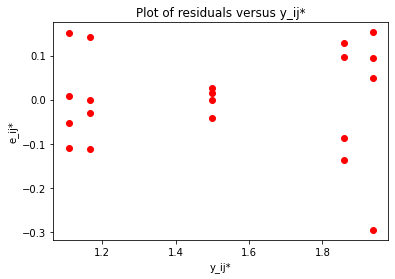

In [6]:
# 对y值进行幂变换，即通过n次方或开方进行方差稳定化变换
lmda = 0.08
sqrt_group1 = group1 ** lmda
sqrt_group2 = group2 ** lmda
sqrt_group3 = group3 ** lmda
sqrt_group4 = group4 ** lmda
sqrt_group5 = group5 ** lmda
sqrt_groups = [sqrt_group1, sqrt_group2, sqrt_group3, sqrt_group4, sqrt_group5]

check_residual(sqrt_groups)

          0         1         2         3
0  4.700480  5.056246  5.267858  5.181784
1  0.000000  0.693147  1.386294  2.890372
2  6.779922  7.135687  8.570924  8.379080
3  6.204558  8.859363  8.576782  9.215328
4  1.945910  1.609438  3.367296  0.693147


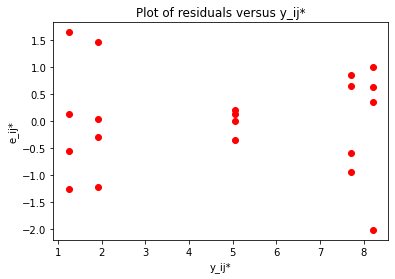

In [7]:
# 对y值进行对数变换，即通过取对数进行方差稳定化变换
log_group1 = np.log(group1)
log_group2 = np.log(group2)
log_group3 = np.log(group3)
log_group4 = np.log(group4)
log_group5 = np.log(group5)
log_groups = [log_group1, log_group2, log_group3, log_group4, log_group5]

check_residual(log_groups)

【补充】Box-Cox变换：Box-Cox变换的主要特点是引入一个参数 $\lambda$，通过数据本身估计该参数进而确定应采取的数据变换形式，Box-Cox变换可以明显地改善数据的正态性、方差齐性。  
Box-Cox变换的一般形式为：  
$$ y(\lambda)=\left\{
\begin{aligned}
\frac{(y+c)^{\lambda}-1}{\lambda} & ,&\lambda \neq 0 \\
\ln (y+c) & ,& \lambda = 0 
\end{aligned}
\right.
$$
式中$y(\lambda)$为经Box-Cox变换后得到的新变量，$y$ 为原始连续因变量，其中 $y+c$ 的 $+c$ 是为了确保 $(y+c)>0$,因为在Box-Cox变换中要求 $y>0$，$\lambda$ 为变换参数。  
在这里可以看到 $\lambda$ 的值是需要我们自己去确定的，那么怎么去确定呢？这里使用的方法是假设经过转换后的因变量就是服从正态分布的，然后画出关于 $\lambda$ 的似然函数，似然函数值最大的时候 $\lambda$ 的取值就是这里需要确定的值。

lmax_mle:  0.016756747738272192
lmax_pearsonr:  0.014405187672448234


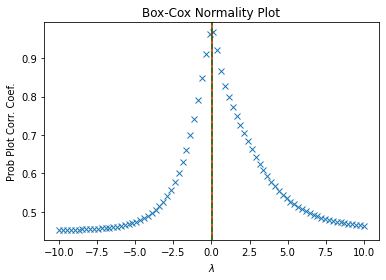

          0         1         2         3
0  4.890554  5.276624  5.507356  5.413405
1  0.000000  0.697188  1.402521  2.961511
2  7.180062  7.579822  9.216959  8.995842
3  6.538571  9.550754  9.223723  9.964921
4  1.977983  1.631337  3.464108  0.697188


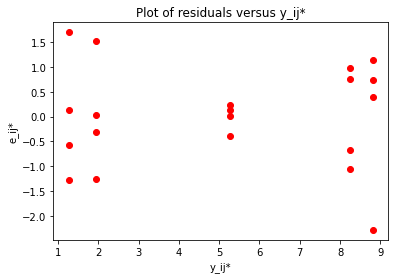

In [8]:
# 作Box-Cox变换
bc, lmax_mle = stats.boxcox(data[:,1])
lmax_pearsonr = stats.boxcox_normmax(data[:,1])
print('lmax_mle: ', lmax_mle)
print('lmax_pearsonr: ', lmax_pearsonr)

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(data[:,1], -10, 10, plot = ax)
ax.axvline(lmax_mle, color='r')
ax.axvline(lmax_pearsonr, color='g', ls='--')
plt.show()

# 计算变换后峰值流量的残差
bc_group1 = bc[0:4]
bc_group2 = bc[4:8]
bc_group3 = bc[8:12]
bc_group4 = bc[12:16]
bc_group5 = bc[16:20]
bc_groups = [bc_group1, bc_group2, bc_group3, bc_group4, bc_group5]

check_residual(bc_groups)

由以上三个变换后得出的数据和图可知，虽然变换后的数据大小不一，但残差与拟合值的关系图都没有呈现漏斗型。这说明经过变换后的数据大致不再具有异方差性，具体的方差齐性检验将在下一问中给出。

**Q4:**

本问的检验假设仍为$H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4$ vs $H_1: \mu_1, \mu_2, \mu_3, \mu_4$不全相等。但此处的平均值是对变换后的数据取得的平均值，而非对原数据取得的平均值。

定义如下函数对数据进行检验。首先使用Levene检验对变换后的数据进行方差齐性检验，然后使用变换后的数据进行方差分析，并打印出方差分析表。函数打印的第一个结果是Levene检验的结果，若接受原假设说明数据具有方差齐性。第二个结果是方差分析的结果，若拒绝原假设说明因子水平显著。

In [9]:
def Levene_and_ANOVA(group1, group2, group3, group4, group5):

    groups = [group1, group2, group3, group4, group5]

    # 变换后，再用Levene检验进行方差齐性检验 
    lene, pVal5 = stats.levene(group1, group2, group3, group4, group5)
    if pVal5 < alpha:
        print('Since p-value < 0.05, reject H0.\n')
    else:
        print('Accept H0\n') 

    # 变换后，Do the one-way ANOVA with transformation
    F0, pVal7 = stats.f_oneway(group1, group2, group3, group4, group5)
    if pVal7 < alpha:
        print('Since p-value < 0.05, reject H0.\n')
    else:
        print('Accept H0\n') 

    # Elegant alternative implementation, with pandas & statsmodels
    for i in range(a):
        data[0 + 4 * i:4 * (i + 1), 1] = list(groups[i])
    df = pd.DataFrame(data, columns = ['method', 'Y'])   
    model = ols('Y ~ C(method)', df).fit()
    anovaResults = anova_lm(model)
    print(anovaResults)

In [10]:
# 幂变换后，进行方差齐性检验和one-way ANOVA
Levene_and_ANOVA(sqrt_group1, sqrt_group2, sqrt_group3, sqrt_group4, sqrt_group5)

Accept H0

Since p-value < 0.05, reject H0.

             df    sum_sq   mean_sq          F        PR(>F)
C(method)   4.0  2.326792  0.581698  35.322436  1.807989e-07
Residual   15.0  0.247023  0.016468        NaN           NaN


In [11]:
# 对数变换后，进行方差齐性检验和one-way ANOVA
Levene_and_ANOVA(log_group1, log_group2, log_group3, log_group4, log_group5)

Accept H0

Since p-value < 0.05, reject H0.

             df      sum_sq    mean_sq         F        PR(>F)
C(method)   4.0  165.056458  41.264114  37.65686  1.176093e-07
Residual   15.0   16.436891   1.095793       NaN           NaN


In [12]:
# bc变换后，进行方差齐性检验和one-way ANOVA
Levene_and_ANOVA(bc_group1, bc_group2, bc_group3, bc_group4, bc_group5)

Accept H0

Since p-value < 0.05, reject H0.

             df      sum_sq    mean_sq          F        PR(>F)
C(method)   4.0  193.668327  48.417082  37.624897  1.182844e-07
Residual   15.0   19.302544   1.286836        NaN           NaN


对三种变换进行检验得到的结果大体上是相同的。由第一个结论可知，稳定化变换后的残差具有方差齐性。再进行单因素方差分析，由方差分析表知，P值均小于0.05且接近于0，故拒绝原假设，即 5 种绝缘材料的性能存在差异。

从最终结果来看，对数变换和bc变换得到的数据大小和方差分析表中的数据比较相似，而幂变换得到的数据比较小，接近于0。这也导致幂变换计算得到的$S_A,\ S_e,\ MS_A,\ MS_e$也远小于另外两种变换的同一统计量。在精度不足时，应尽量选用对数变换和bc变换。

# 第二周作业
計算$E[MS_A],\ E[MS_B],\ E[MS_{AB}],\ E[MS_E].$

解：
$$
E[MS_A]=E[\frac{SS_A}{df_A}]=\frac1{a-1}E[SS_A].\ 令\overline y=\frac1n\Sigma_{i=1}^a\Sigma_{j=1}^b\Sigma_{k=1}^my_{ijk}.\\
\mu_{i..}=\frac1{bm}\Sigma_{j=1}^b\Sigma_{k=1}^m\mu_{ij}=\frac1{bm}\Sigma_{j=1}^b\Sigma_{k=1}^m(\mu+\alpha_i+\beta_j+(\alpha\beta)_{ij})=\mu+\alpha_i+\frac1{b}\Sigma_{j=1}^b(\beta_j+(\alpha\beta)_{ij})=\mu+\alpha_i,\\
E[SS_A]=E[bm\Sigma_{i=1}^a(\overline y_{i..}-\overline y)^2]=bmE[\Sigma_{i=1}^a((\mu_{i..}+\overline\epsilon_{i..})-(\mu+\overline \epsilon))^2]
=bmE[\Sigma_{i=1}^a(\alpha_i+\overline\epsilon_{i..}-\overline \epsilon)^2]\\
=bmE[\Sigma_{i=1}^a(\alpha_i^2+(\overline\epsilon_{i..}-\overline \epsilon)^2+2\alpha_i(\overline\epsilon_{i..}-\overline \epsilon))]=bm\Sigma_{i=1}^a\{E[\alpha_i^2]+E[(\overline\epsilon_{i..}-\overline \epsilon)^2]+2E[\alpha_i(\overline\epsilon_{i..}-\overline \epsilon)]\}=bm\Sigma_{i=1}^a\{\alpha_i^2+E[(\overline\epsilon_{i..}-\overline \epsilon)^2]+2\alpha_iE[\overline\epsilon_{i..}-\overline \epsilon]\}=bm\Sigma_{i=1}^a\{\alpha_i^2+E[(\overline\epsilon_{i..}-\overline \epsilon)^2]\}\\
=bm\Sigma_{i=1}^a\alpha_i^2+E[bm\Sigma_{i=1}^a(\overline\epsilon_{i..}-\overline \epsilon)^2]\\
\because \epsilon_{ijk}\sim N(0,\sigma^2),\therefore \overline\epsilon_{i..}\sim N(0,\frac{\sigma^2}{bm}),\ \therefore\frac{\Sigma_{i=1}^aE[(\overline\epsilon_{i..}-\overline \epsilon)^2]}{\frac{\sigma^2}{bm}}\sim\chi^2(a-1),\therefore E[bm\Sigma_{i=1}^a(\overline\epsilon_{i..}-\overline \epsilon)^2]=(a-1)\sigma^2. \\
\therefore E[SS_A]=(a-1)\sigma^2+bm\Sigma_{i=1}^a\alpha_i^2,\ E[MS_A]=\sigma^2+\frac{bm}{a-1}\Sigma_{i=1}^a\alpha_i^2,\ \mbox{同理可得}E[MS_B]=\sigma^2+\frac{am}{b-1}\Sigma_{j=1}^b\beta_j^2. 
$$

$$
\\E[SS_E]=E[\Sigma_{i=1}^a\Sigma_{j=1}^b\Sigma_{k=1}^m(y_{ijk}-\overline y_{ij.})^2]
=E[\Sigma_{i=1}^a\Sigma_{j=1}^b\Sigma_{k=1}^m(\epsilon_{ijk}-\overline \epsilon_{ij.})^2]=\Sigma_{i=1}^a\Sigma_{j=1}^bE[\Sigma_{k=1}^m(\epsilon_{ijk}-\overline \epsilon_{ij.})^2]\\
\because \epsilon_{ijk}\sim N(0,\sigma^2),\frac1{\sigma^2}\Sigma_{k=1}^m(\epsilon_{ijk}-\overline \epsilon_{ij.})^2\sim\chi^2(m-1), \therefore E[\Sigma_{k=1}^m(\epsilon_{ijk}-\overline \epsilon_{ij.})^2]=(m-1)\sigma^2.\\ 
\therefore E[SS_E]=ab(m-1)\sigma^2=(n-ab)\sigma^2,\ E[MS_E]=E[\frac{SS_E}{df_E}]=\frac1{n-ab}E[SS_E]=\sigma^2.
$$

$$
E[SS_{AB}]=E[m\Sigma_{i=1}^a\Sigma_{j=1}^b(\overline y_{ij.}+\overline y-\overline y_{i..}-\overline y_{.j.})^2]=m\Sigma_{i=1}^a\Sigma_{j=1}^bE[(\overline y_{ij.}+\overline y-\overline y_{i..}-\overline y_{.j.})^2]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^bE[((\mu_{ij.}+\overline\epsilon_{ij.})+(\mu+\overline\epsilon)-(\mu_{i..}+\overline\epsilon_{i..})-(\mu_{.j.}+\overline\epsilon_{.j.}))^2]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^bE[((\alpha\beta)_{ij}+\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.})^2]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^bE[(\alpha\beta)_{ij}^2+(\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.})^2+2(\alpha\beta)_{ij}(\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.})]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2+E[m\Sigma_{i=1}^a\Sigma_{j=1}^b(\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.})^2]+2m\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}E[\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.}]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2+E[m\Sigma_{i=1}^a\Sigma_{j=1}^b(\overline\epsilon_{ij.}+\overline\epsilon-\overline\epsilon_{i..}-\overline\epsilon_{.j.})^2]\\
=m\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2+E[m\Sigma_{i=1}^a\Sigma_{j=1}^b((\overline\epsilon_{ij.}-\overline\epsilon_{i..})-(\overline\epsilon_{.j.}-\overline\epsilon))^2]\\
\because \epsilon_{ijk}\sim N(0,\sigma^2),\therefore \overline\epsilon_{ij.}\sim N(0,\frac{\sigma^2}m),(\overline\epsilon_{ij.}-\overline\epsilon_{i..})\sim N(0,\frac{\sigma^2}m+\frac{\sigma^2}{bm}),\\
\therefore\frac{E[\Sigma_{i=1}^a((\overline\epsilon_{ij.}-\overline\epsilon_{i..})-(\overline\epsilon_{.j.}-\overline\epsilon))^2]}{\frac{\sigma^2}m+\frac{\sigma^2}{bm}}\sim\chi^2(a-1),E[\Sigma_{i=1}^a\Sigma_{j=1}^b((\overline\epsilon_{ij.}-\overline\epsilon_{i..})-(\overline\epsilon_{.j.}-\overline\epsilon))^2]=(a-1)(b-1)\sigma^2.\\
\therefore E[SS_{AB}]=(a-1)(b-1)\sigma^2+m\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2,\\
E[MS_{AB}]=E[\frac{SS_{AB}}{df_{AB}}]=\frac1{(a-1)(b-1)}E[SS_{AB}]=\sigma^2+\frac m{(a-1)(b-1)}\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2.
$$

綜上所述，
$$
E[MS_A]=\sigma^2+\frac{bm}{a-1}\Sigma_{i=1}^a\alpha_i^2,E[MS_B]=\sigma^2+\frac{am}{b-1}\Sigma_{j=1}^b\beta_j^2. \\
E[MS_{AB}]=\sigma^2+\frac m{(a-1)(b-1)}\Sigma_{i=1}^a\Sigma_{j=1}^b(\alpha\beta)_{ij}^2,E[MS_E]=\sigma^2.
$$